We are going to extract our network using data from the RivGraph application [paper](https://esurf.copernicus.org/articles/8/87/2020/esurf-8-87-2020.html) Supplemental data found [here](https://esurf.copernicus.org/articles/8/87/2020/esurf-8-87-2020-supplement.zip). We use this comparison to validate our measure of direction.

In [1]:
import rasterio
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import pyproj
import geopandas as gpd
from rasterio import features
from rasterio.warp import transform_bounds
import scipy.ndimage as nd
from orinoco import (filter_binary_array_by_min_size, 
                     polygonize_array_to_shapefile, 
                     get_cropped_profile,
                     rasterize_shapes_to_array)
from tqdm import tqdm
import scipy.ndimage as nd
from skimage import measure

# Specify the Site Directory

In [2]:
site_name = 'mackenzie'

In [3]:
esurf_data = Path(f'esurf_data/{site_name}')
esurf_data.exists()

True

# Create a Tile Directory for Output Proudcts

We use the tile name to create a directory for our products.

In [4]:
site_dir = Path(f'out/{site_name}')
site_dir.mkdir(exist_ok=True, parents=True)

# Crop The Water Mask Data

Let's first inspect the data.

In [5]:
with rasterio.open(esurf_data/f'{site_name.capitalize()}_dist.tif') as ds:
    # distance == 0 is land and distance > 0 is water
    water_mask = ds.read(1).astype(bool).astype(int)
    profile = ds.profile
profile

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 5564, 'height': 8825, 'count': 1, 'crs': CRS.from_epsg(32608), 'transform': Affine(30.0, 0.0, 413640.0,
       0.0, -30.0, 7744740.0), 'tiled': False, 'compress': 'lzw', 'interleave': 'band'}

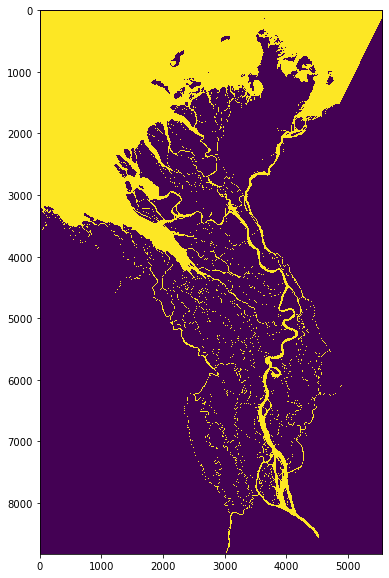

In [6]:
plt.figure(figsize=(10, 10))
plt.imshow(water_mask)

In [7]:
p = profile.copy()
p['dtype'] = 'uint8'
with rasterio.open(site_dir/f'water_mask_{site_name}.tif', 'w', **p) as ds:
    ds.write(water_mask.astype(np.uint8), 1)

# Initialization Mask

We use this hydropolys [dataset](https://apps.gis.ucla.edu/geodata/dataset/world_water_bodies/resource/a6b40af0-84cb-40ce-b1c5-b024527a6943). This is a large dataset and we put it on an external hard drive (update the path below accordingly). The supplemental data has a shoreline. We include both this and the shoreline and remove land areas that are below a threshold.

In [8]:
water_body_shapefile = Path('/Volumes/BigData/river_data/hydropolys')
water_body_shapefile.exists()

True

We utilize rasterio's [`rasterize`](https://rasterio.readthedocs.io/en/latest/topics/features.html#burning-shapes-into-a-raster) to transalte the ocean geometry from the dataset above.

In [9]:
def translate_one(geometry, profile):
    shapes = [(geometry, 1)]
    out_arr = np.zeros((profile['height'], profile['width']))
    burned = features.rasterize(shapes=shapes,
                                out=out_arr,
                                transform=profile['transform'],
                                all_touched=True)
    return burned

We obtain the bounds of our dataset and use this to read a subset of the large shapefile consisting of global waterbodies. Then we translate the shapefile into a raster.

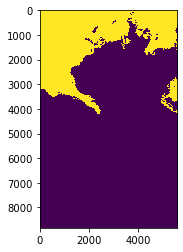

In [12]:
with rasterio.open(site_dir/f'water_mask_{site_name}.tif') as ds:
    bounds = ds.bounds
    crs = str(ds.crs).lower()
    profile = ds.profile
bounds_4326 = transform_bounds(crs, 'epsg:4326', *bounds)
oceanline_df = gpd.read_file(water_body_shapefile, bbox=bounds_4326).to_crs({'init':crs})
oceanline_df = oceanline_df[oceanline_df['TYPE'] == 'Ocean or Sea'].copy()
ocean_geometry = oceanline_df.geometry.unary_union.buffer(1e-9)
ocean_mask = translate_one(ocean_geometry, profile)
plt.imshow(ocean_mask, interpolation='none')

We rasterize the shoreline and remove intermediately sized land bodies as these are the areas between the shoreline and ocean.

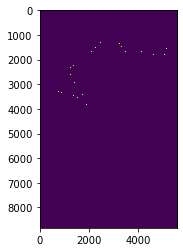

In [13]:
df_shoreline = gpd.read_file(esurf_data/f'{site_name}_shoreline.shp')
shoreline = translate_one(df_shoreline.geometry[0], profile)
shoreline = nd.binary_dilation(shoreline, iterations=1)
plt.imshow(shoreline)

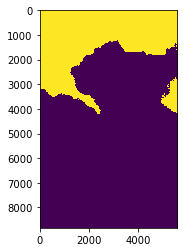

In [14]:
ocean_mask = shoreline.astype(bool) | ocean_mask.astype(bool)
ocean_mask = 1 - filter_binary_array_by_min_size(1 - ocean_mask.astype(int),
                                                 min_size=ocean_mask.size * .2)
plt.imshow(ocean_mask)

We save the raster to our product directory.

In [16]:
with rasterio.open(site_dir/f'ocean_mask_{site_name}.tif', 'w', **p) as ds:
    ds.write(ocean_mask.astype('uint8'), 1)